IMPORTING LIBRARY

In [42]:
# !pip install ydata-profiling

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

LOAD DATA

In [46]:
df_train = pd.read_csv('/content/origin_destination_train_202503.csv')
df_train=df_train.drop(['YEAR_MONTH','PT_TYPE'],axis=1)
df_train['TIME_PER_HOUR'] = pd.to_numeric(df_train['TIME_PER_HOUR'], errors='coerce')

df_mrt = pd.read_csv("/content/mrt.csv")

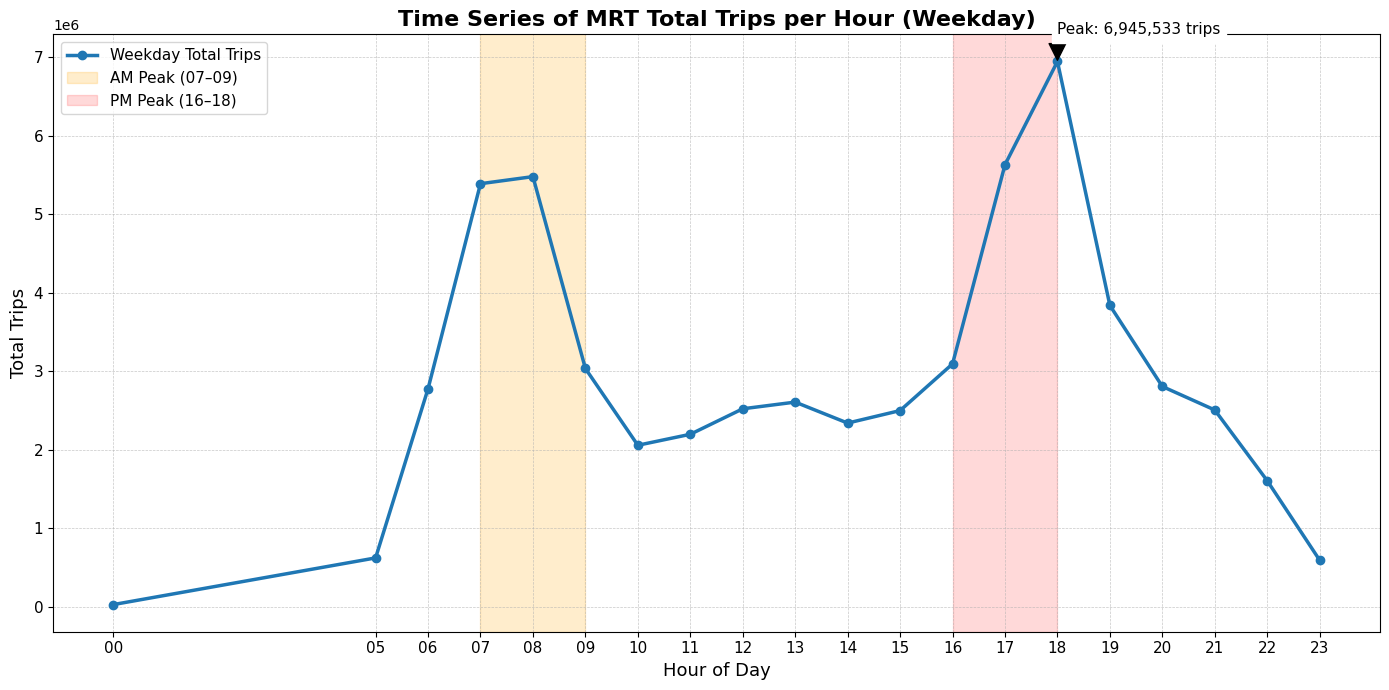

In [44]:
# Exploratory Data
# file = ProfileReport(df_train)
# file.to_notebook_iframe()

# Time Series for the Data Problem
df_train['TIME_PER_HOUR'] = df_train['TIME_PER_HOUR'].astype(str).str.zfill(2)

df_weekday = df_train[df_train['DAY_TYPE'] == 'WEEKDAY'].copy()

time_series = df_weekday.groupby('TIME_PER_HOUR')['TOTAL_TRIPS'].sum().reset_index()
time_series['TIME_PER_HOUR'] = pd.to_datetime(time_series['TIME_PER_HOUR'], format='%H')
time_series = time_series.sort_values('TIME_PER_HOUR').set_index('TIME_PER_HOUR')

# Plotting
# sns.set(style='whitegrid')
plt.figure(figsize=(14, 7))

plt.plot(time_series.index, time_series['TOTAL_TRIPS'], marker='o', color='#1f77b4', linewidth=2.5, label='Weekday Total Trips')

# Area shading for AM peak (07:00–09:00)
plt.axvspan(pd.to_datetime("07", format='%H'), pd.to_datetime("09", format='%H'), color='orange', alpha=0.2, label='AM Peak (07–09)')

# Area shading for PM peak (16:00–18:00)
plt.axvspan(pd.to_datetime("16", format='%H'), pd.to_datetime("18", format='%H'), color='red', alpha=0.15, label='PM Peak (16–18)')

plt.title('Time Series of MRT Total Trips per Hour (Weekday)', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=13)
plt.ylabel('Total Trips', fontsize=13)
plt.xticks(ticks=time_series.index, labels=time_series.index.strftime('%H'), fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper left', fontsize=11, frameon=True)
plt.tight_layout()
peak_hour = time_series['TOTAL_TRIPS'].idxmax()
peak_value = time_series['TOTAL_TRIPS'].max()
plt.annotate(f'Peak: {peak_value:,} trips',
             xy=(peak_hour, peak_value),
             xytext=(peak_hour, peak_value + peak_value*0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=11, backgroundcolor='white')
plt.show()

OD MATRIX

In [47]:
# Filter 7–9
od_am_peak = df_train[
    (df_train['DAY_TYPE'] == 'WEEKDAY') &
    (df_train['TIME_PER_HOUR'] >= 7) &
    (df_train['TIME_PER_HOUR'] <= 9)
].drop(columns=['DAY_TYPE'])

# Grouping & Aggregation
od_am_peak = od_am_peak.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']) \
                            .sum(numeric_only=True) \
                            .reset_index() \
                            .drop(columns=['TIME_PER_HOUR'])

In [48]:
# Filter 16–18
od_pm_peak = df_train[
    (df_train['DAY_TYPE'] == 'WEEKDAY') &
    (df_train['TIME_PER_HOUR'] >= 16) &
    (df_train['TIME_PER_HOUR'] <= 18)
].drop(columns=['DAY_TYPE'])

# Grouping & Aggregation
od_pm_peak = od_pm_peak.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']) \
                            .sum(numeric_only=True) \
                            .reset_index() \
                            .drop(columns=['TIME_PER_HOUR'])

In [49]:
od_am_peak.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].transform('sum')
od_am_peak['sum_total_trips_origin']=od_am_peak.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].transform('sum')
od_am_peak['pct_trips_sum_origin']=od_am_peak['TOTAL_TRIPS']/od_am_peak['sum_total_trips_origin']

#Creating OD matrix with origins as rows and destinations as columns, values as the normalised trips by origin
od_am_peak = od_am_peak.pivot(index='ORIGIN_PT_CODE',columns='DESTINATION_PT_CODE',values='pct_trips_sum_origin').fillna(0)
od_am_peak
od_am_peak.to_csv('od_am_peak.csv')

In [50]:
od_pm_peak.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].transform('sum')
od_pm_peak['sum_total_trips_origin']=od_pm_peak.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].transform('sum')
od_pm_peak['pct_trips_sum_origin']=od_pm_peak['TOTAL_TRIPS']/od_pm_peak['sum_total_trips_origin']

#Creating OD matrix with origins as rows and destinations as columns, values as the normalised trips by origin
od_pm_peak = od_pm_peak.pivot(index='ORIGIN_PT_CODE',columns='DESTINATION_PT_CODE',values='pct_trips_sum_origin').fillna(0)
od_pm_peak
od_pm_peak.to_csv('od_pm_peak.csv')